Starting DCF Model Analysis...
Reading Excel file: F:\tesla-optimus-business-analysis\data\processed\08_Model_3_Y_DCF.xlsx
Available sheets: ['Battery Pack Cost Breakdown', 'Battery Pack Cost', 'Cost Data and Assumptions', 'Vehicle Cost Calculation', 'Model Assumptions', 'NPV Forecast', 'Sensitivity Analysis', 'Investment Return Analysis']

Processing sheet 1/3: NPV Forecast
Cleaning NPV Forecast sheet...
Successfully cleaned 3 scenarios

Creating NPV Forecast visualizations...

--- Normal Scenario ---
FCF Years: ['2026E', '2027E', '2028E', '2029E', '2030E']
Raw FCF Values: [5100.720000000001, 3083.3929728000003, 2723.555742435199, 2413.6195275439227, 2213.9431661258022]
Initial Investment: 12000
Adjusted 2026 FCF: -6899.279999999999 (original: 5100.720000000001)
Adjusted FCF Values: [-6899.279999999999, 3083.3929728000003, 2723.555742435199, 2413.6195275439227, 2213.9431661258022]
EBIT Years: ['2026E', '2027E', '2028E', '2029E', '2030E']
EBIT Values: [2763.2000000000007, 2631.379968, 

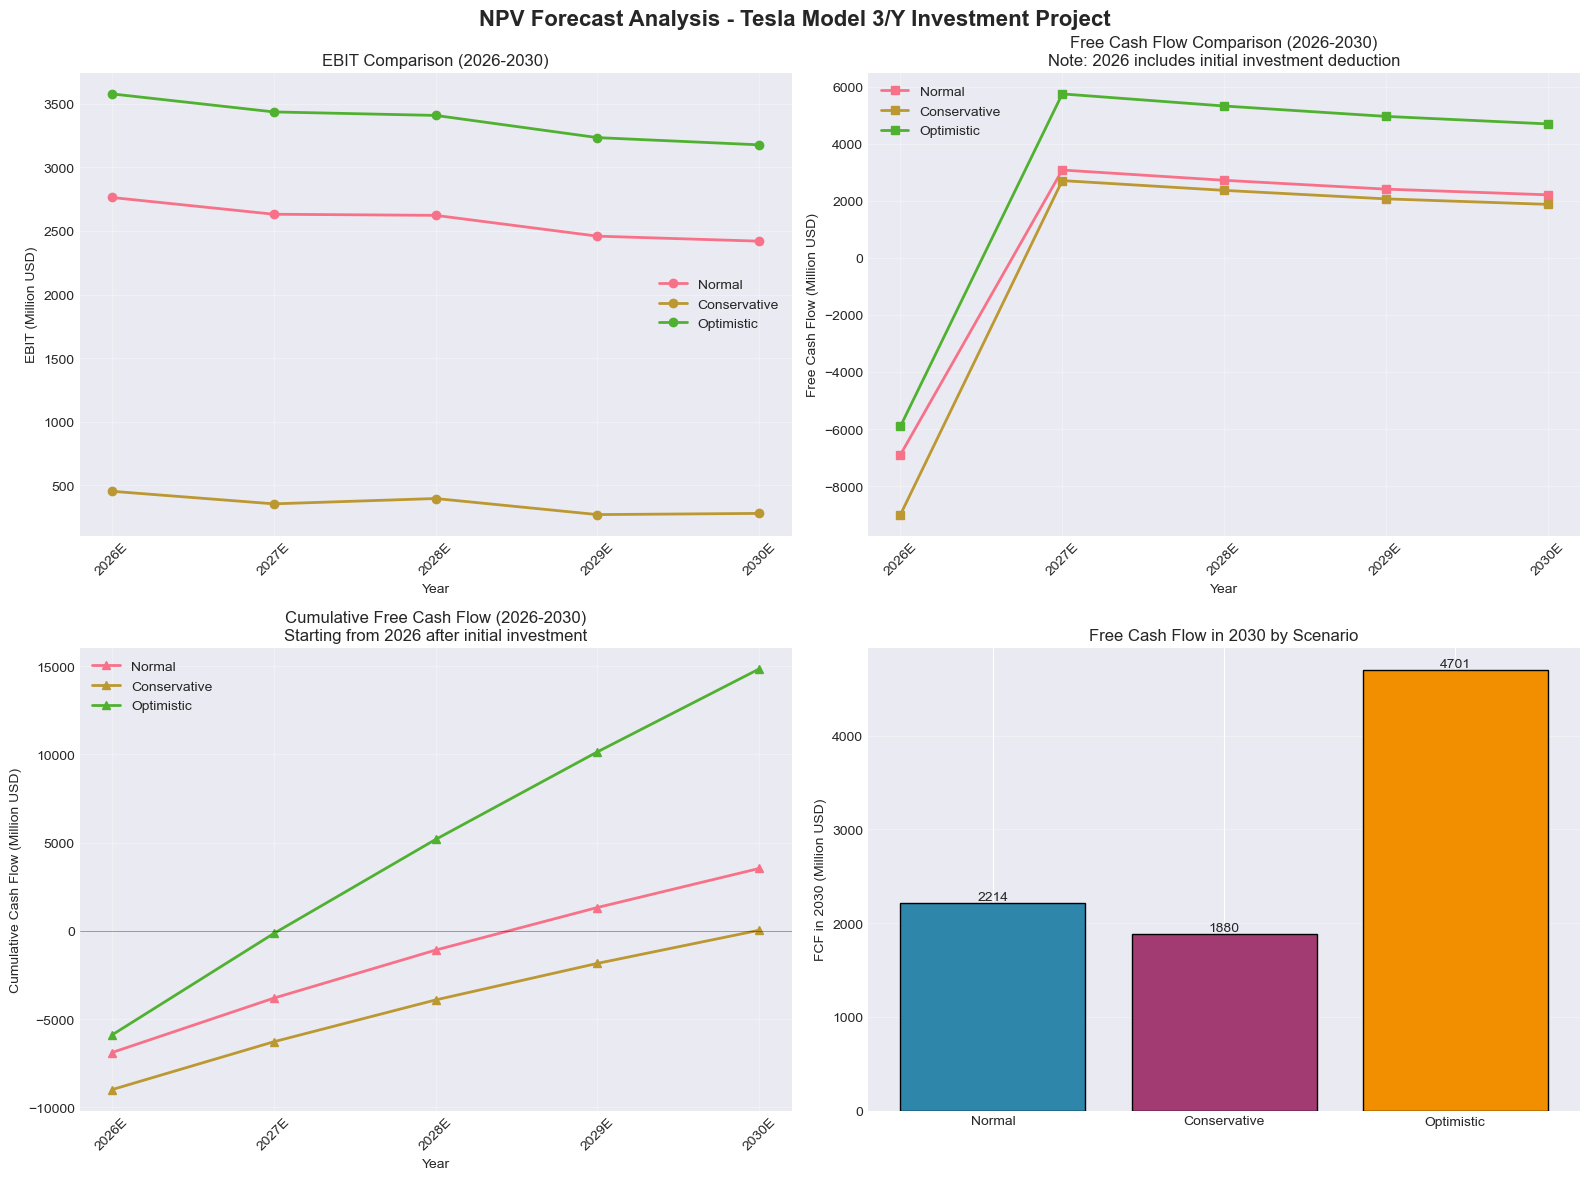


DETAILED FREE CASH FLOW ANALYSIS

Normal Scenario:
----------------------------------------
Year       Raw FCF         Initial Investment   Adjusted FCF    Cumulative FCF 
----------------------------------------
2026E      5101            -12000               -6899          -6899          
2027E      3083            -                    3083           -3816          
2028E      2724            -                    2724           -1092          
2029E      2414            -                    2414           1321           
2030E      2214            -                    2214           3535           

Conservative Scenario:
----------------------------------------
Year       Raw FCF         Initial Investment   Adjusted FCF    Cumulative FCF 
----------------------------------------
2026E      2998            -12000               -9002          -9002          
2027E      2713            -                    2713           -6288          
2028E      2370            -                   

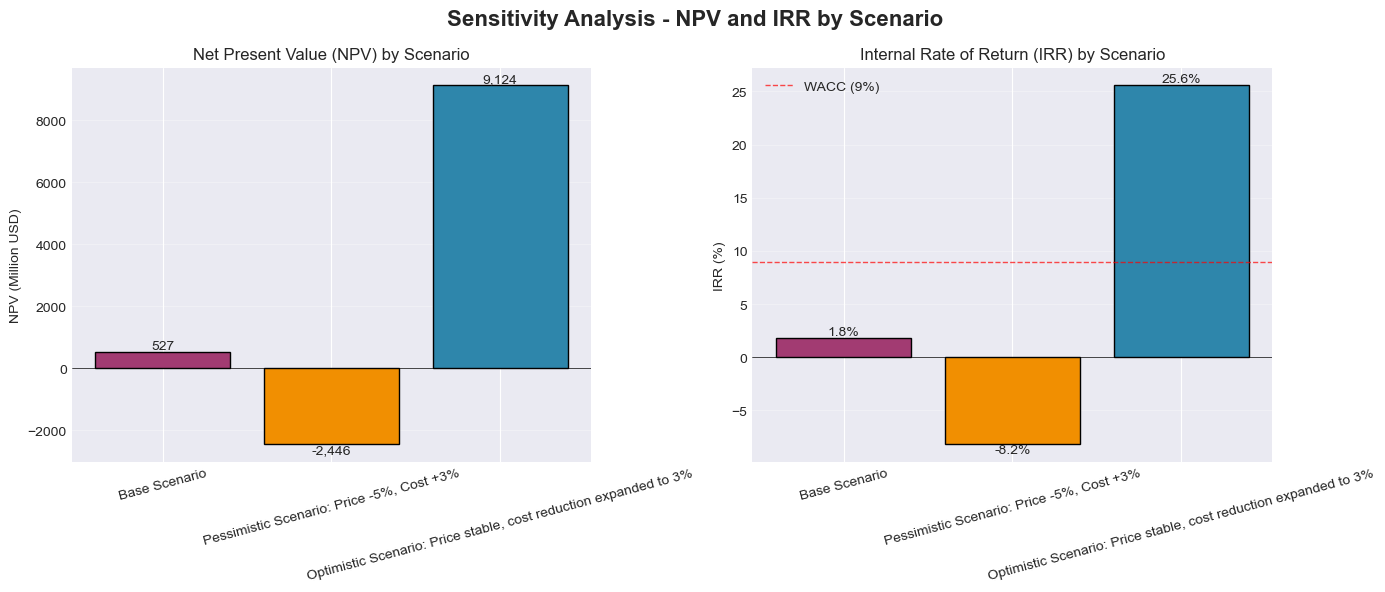


Processing sheet 3/3: Investment Return Analysis
Cleaning Investment Return Analysis sheet...
DataFrame shape: (6, 6)
Using default data for Investment Return Analysis

Successfully extracted 3 scenarios

Creating Investment Return Analysis visualizations...
Scenarios available: ['Normal', 'Conservative', 'Optimistic']


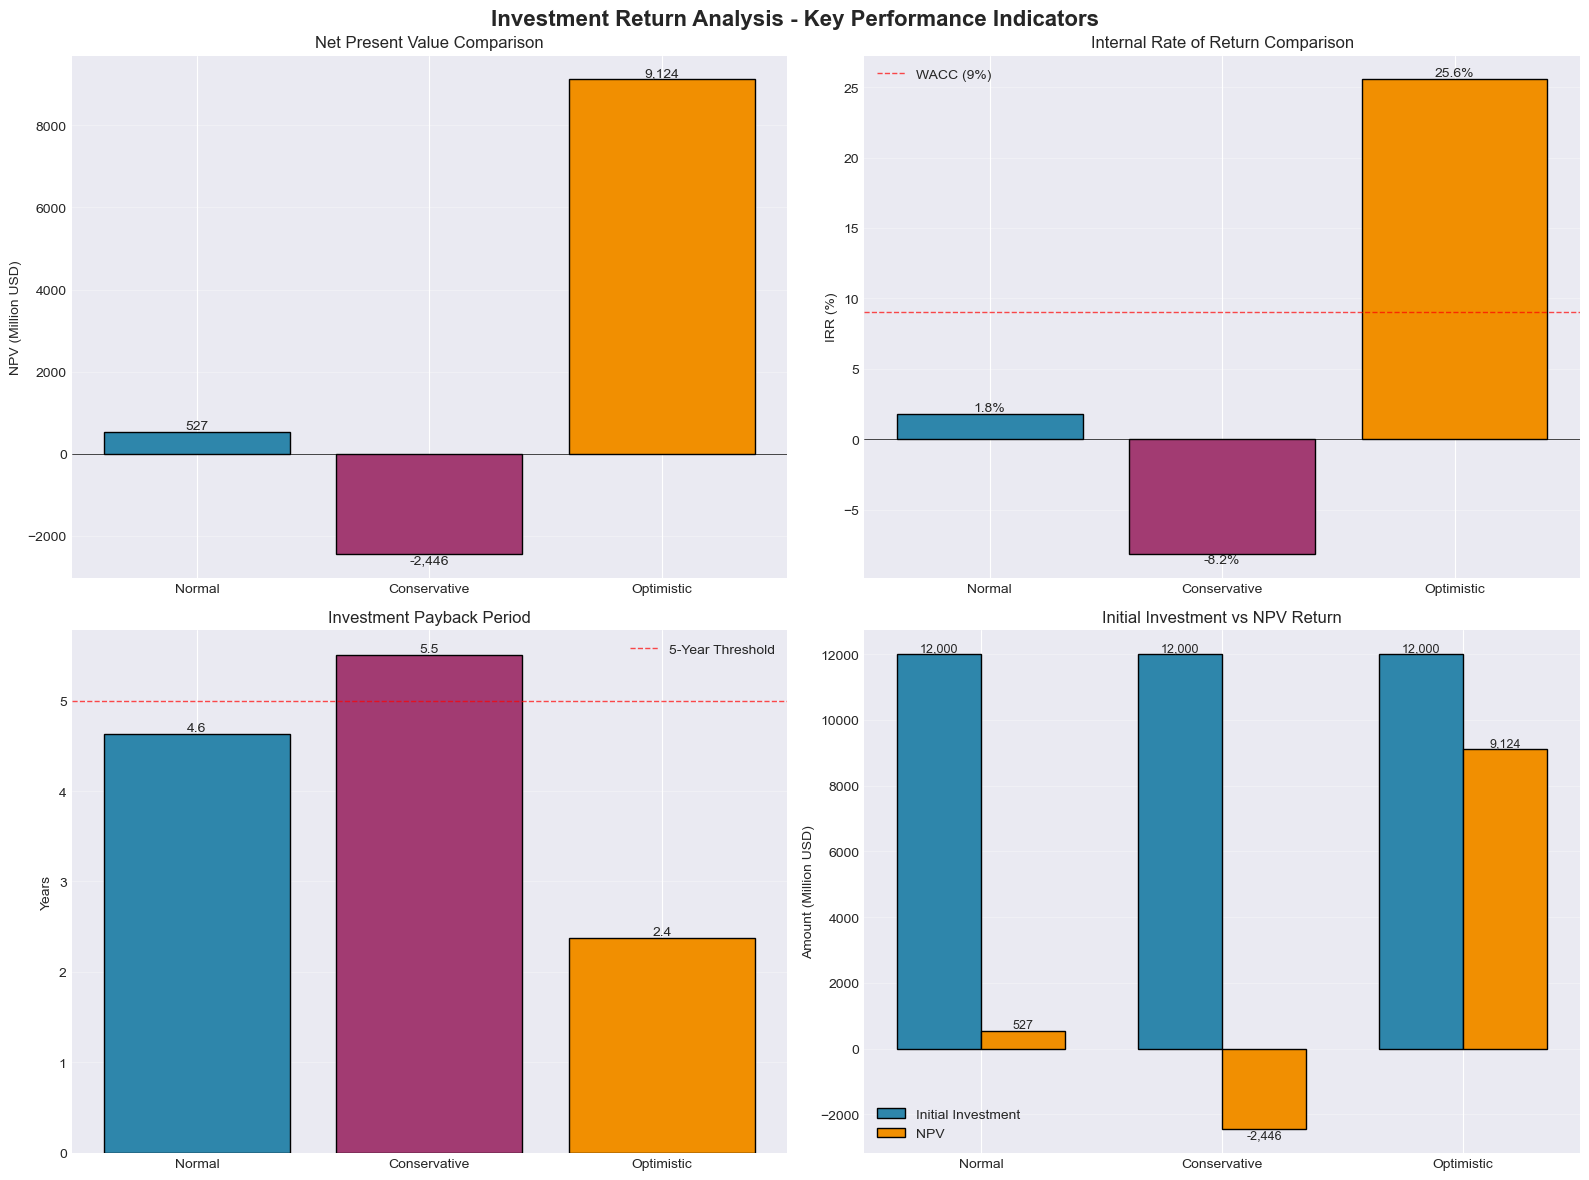


Analysis completed successfully!
Visualizations have been saved as PNG files in the current directory.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import re
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define relative paths
data_dir = Path("F:/tesla-optimus-business-analysis/data/processed")
excel_file = data_dir / "08_Model_3_Y_DCF.xlsx"

def clean_npv_forecast(df):
    """Clean NPV Forecast sheet"""
    print("Cleaning NPV Forecast sheet...")
    
    # Find the start of each scenario
    scenario_starts = []
    for i in range(len(df)):
        cell_value = df.iloc[i, 0]
        if isinstance(cell_value, str):
            if 'Project (' in cell_value:
                scenario_starts.append(i)
            elif '项目' in cell_value:  # Chinese version check
                scenario_starts.append(i)
    
    if len(scenario_starts) != 3:
        print(f"Warning: Expected 3 scenarios, found {len(scenario_starts)}")
        # Try alternative search
        for i in range(len(df)):
            cell_value = df.iloc[i, 0]
            if isinstance(cell_value, str) and ('Normal' in cell_value or 'Conservative' in cell_value or 'Optimistic' in cell_value):
                if i not in scenario_starts:
                    scenario_starts.append(i)
    
    # Clean each scenario
    cleaned_data = {}
    scenario_names = ['Normal', 'Conservative', 'Optimistic']
    
    for idx, start in enumerate(scenario_starts):
        if idx < len(scenario_starts) - 1:
            end = scenario_starts[idx + 1]
        else:
            end = len(df)
        
        scenario_df = df.iloc[start:end].reset_index(drop=True)
        scenario_name = scenario_names[idx] if idx < len(scenario_names) else f"Scenario_{idx}"
        
        # Remove completely empty rows and columns
        scenario_df = scenario_df.dropna(how='all', axis=0)
        scenario_df = scenario_df.dropna(how='all', axis=1)
        
        # Reset column names - use first row
        scenario_df.columns = scenario_df.iloc[0]
        scenario_df = scenario_df[1:].reset_index(drop=True)
        
        # Clean column names
        scenario_df.columns = [str(col).strip() for col in scenario_df.columns]
        
        # Convert numeric columns
        for col in scenario_df.columns[1:]:
            try:
                scenario_df[col] = pd.to_numeric(scenario_df[col], errors='coerce')
            except:
                scenario_df[col] = scenario_df[col]
        
        scenario_df['Scenario'] = scenario_name
        cleaned_data[scenario_name] = scenario_df
    
    return cleaned_data

def extract_financial_data(df, data_type='fcf'):
    """Extract financial data from cleaned NPV forecast DataFrame"""
    # Convert first column to string for searching
    first_col = df.iloc[:, 0].astype(str).str.strip()
    
    if data_type == 'fcf':
        # Look for Free Cash Flow rows
        search_patterns = ['Project Free Cash Flow', 'Free Cash Flow', '10. Project Free Cash Flow', 
                          'FCF', '现金流', '自由现金流']
    elif data_type == 'ebit':
        # Look for EBIT rows
        search_patterns = ['EBIT', '4. EBIT', 'Earnings Before Interest and Taxes', 
                          '息税前利润', '经营利润']
    else:
        search_patterns = [data_type]
    
    for pattern in search_patterns:
        mask = first_col.str.contains(pattern, case=False, na=False)
        if mask.any():
            target_row = df[mask].iloc[0]
            
            # Extract data from year columns (2026E, 2027E, etc.) only
            year_data = []
            years = []
            
            for i in range(1, len(df.columns) - 1):  # Skip first (description) and last (Scenario) columns
                col_name = str(df.columns[i]).strip()
                value = target_row[i]
                
                # Only include columns that are actual forecast years (2026E, 2027E, etc.)
                if re.search(r'202[6-9]E|2030E', col_name):
                    years.append(col_name)
                    
                    if pd.notna(value):
                        try:
                            # Remove commas and convert to float
                            if isinstance(value, str):
                                value = float(value.replace(',', ''))
                            year_data.append(float(value))
                        except:
                            year_data.append(np.nan)
                    else:
                        year_data.append(np.nan)
            
            if years and any(pd.notna(v) for v in year_data):
                return years, year_data
    
    # If no pattern found, try to find by position
    print(f"Warning: Could not find {data_type} using patterns, trying positional search")
    
    # For EBIT, it's usually row 4 (0-indexed)
    if data_type == 'ebit' and len(df) > 4:
        target_row = df.iloc[3]  # Row 4 (0-indexed)
    # For FCF, it's usually row 10 (0-indexed)
    elif data_type == 'fcf' and len(df) > 10:
        target_row = df.iloc[9]  # Row 10 (0-indexed)
    else:
        return [], []
    
    # Extract data for forecast years only
    year_data = []
    years = []
    
    for i in range(1, len(df.columns) - 1):
        col_name = str(df.columns[i]).strip()
        value = target_row[i]
        
        # Only include forecast years
        if re.search(r'202[6-9]E|2030E', col_name):
            if pd.notna(value):
                try:
                    if isinstance(value, str):
                        value = float(value.replace(',', ''))
                    year_data.append(float(value))
                    years.append(col_name)
                except:
                    pass
    
    return years, year_data

def get_initial_investment_for_fcf(scenario_name):
    """Get initial investment amount for a given scenario"""
    # Based on the Excel data, initial investment is 12000 for all scenarios
    return 12000

def visualize_npv_forecast(cleaned_data):
    """Create visualizations for NPV Forecast - FIXED cumulative FCF calculation"""
    print("\nCreating NPV Forecast visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NPV Forecast Analysis - Tesla Model 3/Y Investment Project', fontsize=16, fontweight='bold')
    
    # Extract data for each scenario
    scenario_fcf_data = {}
    scenario_ebit_data = {}
    
    for scenario_name, df in cleaned_data.items():
        print(f"\n--- {scenario_name} Scenario ---")
        
        # Extract FCF data (forecast years only)
        years_fcf, fcf_values = extract_financial_data(df, 'fcf')
        if years_fcf and fcf_values:
            print(f"FCF Years: {years_fcf}")
            print(f"Raw FCF Values: {fcf_values}")
            
            # ADJUSTMENT: Subtract initial investment from 2026 FCF only
            adjusted_fcf = fcf_values.copy()
            if len(adjusted_fcf) > 0 and '2026E' in years_fcf:
                initial_investment = get_initial_investment_for_fcf(scenario_name)
                # Find index of 2026E
                idx_2026 = years_fcf.index('2026E') if '2026E' in years_fcf else 0
                adjusted_fcf[idx_2026] = fcf_values[idx_2026] - initial_investment
                print(f"Initial Investment: {initial_investment}")
                print(f"Adjusted 2026 FCF: {adjusted_fcf[idx_2026]} (original: {fcf_values[idx_2026]})")
            
            scenario_fcf_data[scenario_name] = {
                'years': years_fcf, 
                'values': adjusted_fcf,
                'raw_values': fcf_values
            }
            print(f"Adjusted FCF Values: {adjusted_fcf}")
        else:
            print(f"Warning: No FCF data found for {scenario_name}")
        
        # Extract EBIT data (forecast years only)
        years_ebit, ebit_values = extract_financial_data(df, 'ebit')
        if years_ebit and ebit_values:
            scenario_ebit_data[scenario_name] = {'years': years_ebit, 'values': ebit_values}
            print(f"EBIT Years: {years_ebit}")
            print(f"EBIT Values: {ebit_values}")
        else:
            print(f"Warning: No EBIT data found for {scenario_name}")
    
    # Determine common years for plotting (forecast years only)
    all_years = []
    for data_dict in [scenario_fcf_data, scenario_ebit_data]:
        for scenario_name, data in data_dict.items():
            if 'years' in data:
                all_years.extend(data['years'])
    
    if all_years:
        # Sort years properly (2026E, 2027E, 2028E, 2029E, 2030E)
        unique_years = sorted(set(all_years), key=lambda x: int(x[:4]) if x[:4].isdigit() else 0)
    else:
        # Use default forecast years
        unique_years = ['2026E', '2027E', '2028E', '2029E', '2030E']
    
    print(f"\nForecast years for plotting: {unique_years}")
    
    # 1. EBIT Comparison across scenarios
    ax1 = axes[0, 0]
    has_ebit_data = False
    
    for scenario_name, data in scenario_ebit_data.items():
        if data['values']:
            # Align data with unique years
            aligned_values = []
            for year in unique_years:
                if year in data['years']:
                    idx = data['years'].index(year)
                    aligned_values.append(data['values'][idx])
                else:
                    aligned_values.append(np.nan)
            
            ax1.plot(unique_years, aligned_values, marker='o', linewidth=2, label=scenario_name)
            has_ebit_data = True
    
    ax1.set_title('EBIT Comparison (2026-2030)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('EBIT (Million USD)')
    if has_ebit_data:
        ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'No EBIT data available', transform=ax1.transAxes, 
                ha='center', va='center', fontsize=12, color='red')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Free Cash Flow Comparison (with adjusted 2026 values)
    ax2 = axes[0, 1]
    has_fcf_data = False
    
    for scenario_name, data in scenario_fcf_data.items():
        if data['values']:
            # Align data with unique years
            aligned_values = []
            for year in unique_years:
                if year in data['years']:
                    idx = data['years'].index(year)
                    aligned_values.append(data['values'][idx])
                else:
                    aligned_values.append(np.nan)
            
            ax2.plot(unique_years, aligned_values, marker='s', linewidth=2, label=scenario_name)
            has_fcf_data = True
    
    ax2.set_title('Free Cash Flow Comparison (2026-2030)\nNote: 2026 includes initial investment deduction')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Free Cash Flow (Million USD)')
    if has_fcf_data:
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No FCF data available', transform=ax2.transAxes, 
                ha='center', va='center', fontsize=12, color='red')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Cumulative Cash Flow - FIXED: Only forecast years, starting from 2026
    ax3 = axes[1, 0]
    has_cumulative_data = False
    
    for scenario_name, data in scenario_fcf_data.items():
        if data['values']:
            # Get FCF values for forecast years only
            fcf_values = np.array(data['values'])
            
            # Calculate cumulative cash flow starting from 2026
            cumulative = np.cumsum(fcf_values)
            
            ax3.plot(data['years'], cumulative, marker='^', linewidth=2, label=scenario_name)
            has_cumulative_data = True
            
            print(f"\n{scenario_name} Cumulative FCF Calculation:")
            print(f"Years: {data['years']}")
            print(f"FCF values (adjusted): {fcf_values}")
            print(f"Cumulative: {cumulative}")
    
    ax3.set_title('Cumulative Free Cash Flow (2026-2030)\nStarting from 2026 after initial investment')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Cumulative Cash Flow (Million USD)')
    if has_cumulative_data:
        ax3.legend()
        
        # Add zero line for reference
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Add grid for better readability
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No cumulative data available', transform=ax3.transAxes, 
                ha='center', va='center', fontsize=12, color='red')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Bar chart of final year cash flows (2030 values)
    ax4 = axes[1, 1]
    scenario_names_bar = []
    final_fcf_values = []
    
    for scenario_name, data in scenario_fcf_data.items():
        if data['values'] and data['years']:
            # Find 2030E value
            if '2030E' in data['years']:
                idx_2030 = data['years'].index('2030E')
                final_value = data['values'][idx_2030]
                scenario_names_bar.append(scenario_name)
                final_fcf_values.append(final_value)
            else:
                # Use last available year
                final_value = data['values'][-1]
                scenario_names_bar.append(scenario_name)
                final_fcf_values.append(final_value)
    
    if scenario_names_bar:
        colors = ['#2E86AB', '#A23B72', '#F18F01']
        bars = ax4.bar(scenario_names_bar, final_fcf_values, color=colors, edgecolor='black')
        ax4.set_title('Free Cash Flow in 2030 by Scenario')
        ax4.set_ylabel('FCF in 2030 (Million USD)')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}', ha='center', va='bottom' if height >= 0 else 'top')
    else:
        ax4.text(0.5, 0.5, 'No final FCF data available', transform=ax4.transAxes, 
                ha='center', va='center', fontsize=12, color='red')
    
    plt.tight_layout()
    plt.savefig('npv_forecast_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create an additional detailed table of FCF calculations
    print("\n" + "="*80)
    print("DETAILED FREE CASH FLOW ANALYSIS")
    print("="*80)
    
    for scenario_name, data in scenario_fcf_data.items():
        if data['values']:
            print(f"\n{scenario_name} Scenario:")
            print("-" * 40)
            print(f"{'Year':<10} {'Raw FCF':<15} {'Initial Investment':<20} {'Adjusted FCF':<15} {'Cumulative FCF':<15}")
            print("-" * 40)
            
            cumulative = 0
            initial_investment = get_initial_investment_for_fcf(scenario_name)
            
            for i, year in enumerate(data['years']):
                raw_fcf = data['raw_values'][i] if i < len(data['raw_values']) else 0
                adjusted_fcf = data['values'][i]
                
                # For 2026, show the deduction
                if year == '2026E':
                    print(f"{year:<10} {raw_fcf:<15.0f} -{initial_investment:<19.0f} {adjusted_fcf:<15.0f}", end="")
                else:
                    print(f"{year:<10} {raw_fcf:<15.0f} {'-':<20} {adjusted_fcf:<15.0f}", end="")
                
                cumulative += adjusted_fcf
                print(f"{cumulative:<15.0f}")

def clean_sensitivity_analysis(df):
    """Clean Sensitivity Analysis sheet"""
    print("Cleaning Sensitivity Analysis sheet...")
    
    # Basic cleaning
    df_clean = df.copy()
    df_clean = df_clean.dropna(how='all', axis=0)
    df_clean = df_clean.dropna(how='all', axis=1)
    
    # Reset index
    df_clean = df_clean.reset_index(drop=True)
    
    # Ensure proper column names
    if df_clean.shape[1] >= 3:
        df_clean.columns = ['Change Factor', 'NPV (Million USD)', 'IRR']
    elif df_clean.shape[1] == 2:
        df_clean.columns = ['Change Factor', 'NPV (Million USD)']
        df_clean['IRR'] = np.nan
    
    # Convert numeric columns
    if 'NPV (Million USD)' in df_clean.columns:
        df_clean['NPV (Million USD)'] = pd.to_numeric(df_clean['NPV (Million USD)'], errors='coerce')
    if 'IRR' in df_clean.columns:
        df_clean['IRR'] = pd.to_numeric(df_clean['IRR'], errors='coerce')
    
    return df_clean

def clean_investment_return_analysis(df):
    """Clean Investment Return Analysis sheet"""
    print("Cleaning Investment Return Analysis sheet...")
    
    # Basic cleaning
    df_clean = df.copy()
    df_clean = df_clean.dropna(how='all', axis=0)
    df_clean = df_clean.dropna(how='all', axis=1)
    
    # Reset index
    df_clean = df_clean.reset_index(drop=True)
    
    print(f"DataFrame shape: {df_clean.shape}")
    
    # Try to extract data from the Excel structure
    scenarios = {}
    
    # Check if we have the expected 9-column structure
    if df_clean.shape[1] >= 9:
        # Extract Normal scenario (columns 0-2)
        normal_df = df_clean.iloc[:, 0:3].copy()
        normal_df.columns = ['Indicator', 'Calculation Result', 'Extra']
        normal_df = normal_df.dropna(subset=['Indicator'])
        normal_df['Indicator'] = normal_df['Indicator'].astype(str).str.strip()
        scenarios['Normal'] = normal_df[['Indicator', 'Calculation Result']]
        
        # Extract Conservative scenario (columns 3-5)
        conservative_df = df_clean.iloc[:, 3:6].copy()
        conservative_df.columns = ['Indicator', 'Calculation Result', 'Extra']
        conservative_df = conservative_df.dropna(subset=['Indicator'])
        conservative_df['Indicator'] = conservative_df['Indicator'].astype(str).str.strip()
        scenarios['Conservative'] = conservative_df[['Indicator', 'Calculation Result']]
        
        # Extract Optimistic scenario (columns 6-8)
        optimistic_df = df_clean.iloc[:, 6:9].copy()
        optimistic_df.columns = ['Indicator', 'Calculation Result', 'Extra']
        optimistic_df = optimistic_df.dropna(subset=['Indicator'])
        optimistic_df['Indicator'] = optimistic_df['Indicator'].astype(str).str.strip()
        scenarios['Optimistic'] = optimistic_df[['Indicator', 'Calculation Result']]
    else:
        # Use default data from the provided Excel content
        print("Using default data for Investment Return Analysis")
        
        scenarios['Normal'] = pd.DataFrame({
            'Indicator': ['1. Initial Investment Amount (End of 2025)', 
                         '2. Sum of Present Value of Next 5 Years Cash Flows', 
                         '3. Net Present Value (NPV) (Million USD)', 
                         '4. Internal Rate of Return (IRR)', 
                         '5. Investment Payback Period (Years)'],
            'Calculation Result': [12000, 12526.654635323166, 526.6546353231661, 
                                  0.018099666710980955, 4.633990858362756]
        })
        
        scenarios['Conservative'] = pd.DataFrame({
            'Indicator': ['1. Initial Investment Amount (End of 2025)', 
                         '2. Sum of Present Value of Next 5 Years Cash Flows', 
                         '3. Net Present Value (NPV) (Million USD)', 
                         '4. Internal Rate of Return (IRR)', 
                         '5. Investment Payback Period (Years)'],
            'Calculation Result': [12000, 9554.41211370905, -2445.5878862909503, 
                                  -0.08163603513055151, 'More than 5 years']
        })
        
        scenarios['Optimistic'] = pd.DataFrame({
            'Indicator': ['1. Initial Investment Amount (End of 2025)', 
                         '2. Sum of Present Value of Next 5 Years Cash Flows', 
                         '3. Net Present Value (NPV) (Million USD)', 
                         '4. Internal Rate of Return (IRR)', 
                         '5. Investment Payback Period (Years)'],
            'Calculation Result': [12000, 21123.906985982867, 9123.906985982867, 
                                  0.25559043380612056, 2.379963974982581]
        })
    
    return scenarios

def visualize_sensitivity_analysis(df):
    """Create visualizations for Sensitivity Analysis"""
    print("\nCreating Sensitivity Analysis visualizations...")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Sensitivity Analysis - NPV and IRR by Scenario', fontsize=16, fontweight='bold')
    
    # 1. NPV Comparison
    ax1 = axes[0]
    scenarios = df['Change Factor'].values
    npv_values = df['NPV (Million USD)'].values
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    bars1 = ax1.bar(scenarios, npv_values, color=colors, edgecolor='black')
    ax1.set_title('Net Present Value (NPV) by Scenario')
    ax1.set_ylabel('NPV (Million USD)')
    ax1.tick_params(axis='x', rotation=15)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # Add zero line
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 2. IRR Comparison
    ax2 = axes[1]
    irr_values = df['IRR'].values * 100  # Convert to percentage
    
    bars2 = ax2.bar(scenarios, irr_values, color=colors, edgecolor='black')
    ax2.set_title('Internal Rate of Return (IRR) by Scenario')
    ax2.set_ylabel('IRR (%)')
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    
    # Add zero line
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add required rate of return line (9% WACC)
    ax2.axhline(y=9, color='red', linestyle='--', linewidth=1, alpha=0.7, label='WACC (9%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_investment_return_analysis(scenarios):
    """Create visualizations for Investment Return Analysis"""
    print("\nCreating Investment Return Analysis visualizations...")
    
    # Ensure we have all three scenarios
    required_scenarios = ['Normal', 'Conservative', 'Optimistic']
    for scenario in required_scenarios:
        if scenario not in scenarios:
            print(f"Warning: {scenario} scenario missing, using default data")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Investment Return Analysis - Key Performance Indicators', fontsize=16, fontweight='bold')
    
    # Extract data for comparison
    scenario_names = list(scenarios.keys())
    print(f"Scenarios available: {scenario_names}")
    
    # Prepare data for each indicator
    indicators = ['3. Net Present Value (NPV) (Million USD)',
                 '4. Internal Rate of Return (IRR)',
                 '5. Investment Payback Period (Years)']
    
    data_dict = {}
    for indicator in indicators:
        data_dict[indicator] = []
        for scenario in scenario_names:
            df = scenarios[scenario]
            # Find the indicator row
            matches = df[df['Indicator'].str.contains(indicator.split('. ')[-1], case=False, na=False)]
            if not matches.empty:
                value = matches.iloc[0]['Calculation Result']
            else:
                # Try exact match
                exact_match = df[df['Indicator'] == indicator]
                value = exact_match.iloc[0]['Calculation Result'] if not exact_match.empty else 0
            
            if indicator == '5. Investment Payback Period (Years)' and isinstance(value, str) and 'More than' in value:
                data_dict[indicator].append(5.5)  # Represent as 5.5 years
            else:
                try:
                    data_dict[indicator].append(float(value))
                except:
                    data_dict[indicator].append(0)
    
    # 1. NPV Comparison
    ax1 = axes[0, 0]
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    bars1 = ax1.bar(scenario_names, data_dict[indicators[0]], color=colors, edgecolor='black')
    ax1.set_title('Net Present Value Comparison')
    ax1.set_ylabel('NPV (Million USD)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # Add zero line
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # 2. IRR Comparison
    ax2 = axes[0, 1]
    irr_values = []
    for val in data_dict[indicators[1]]:
        if abs(val) < 1:  # If it's a decimal (0.018, -0.081, 0.255)
            irr_values.append(val * 100)
        else:
            irr_values.append(val)
    
    bars2 = ax2.bar(scenario_names, irr_values, color=colors, edgecolor='black')
    ax2.set_title('Internal Rate of Return Comparison')
    ax2.set_ylabel('IRR (%)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    
    # Add zero line
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.axhline(y=9, color='red', linestyle='--', linewidth=1, alpha=0.7, label='WACC (9%)')
    ax2.legend()
    
    # 3. Payback Period Comparison
    ax3 = axes[1, 0]
    payback_values = data_dict[indicators[2]]
    bars3 = ax3.bar(scenario_names, payback_values, color=colors, edgecolor='black')
    ax3.set_title('Investment Payback Period')
    ax3.set_ylabel('Years')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')
    
    # Add 5-year threshold line
    ax3.axhline(y=5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='5-Year Threshold')
    ax3.legend()
    
    # 4. Initial Investment vs NPV
    ax4 = axes[1, 1]
    
    # Get initial investment values
    initial_investments = []
    for scenario in scenario_names:
        df = scenarios[scenario]
        matches = df[df['Indicator'].str.contains('Initial Investment', case=False, na=False)]
        if not matches.empty:
            value = matches.iloc[0]['Calculation Result']
        else:
            value = 12000  # Default
        
        try:
            initial_investments.append(float(value))
        except:
            initial_investments.append(12000)
    
    width = 0.35
    x = np.arange(len(scenario_names))
    
    bars4a = ax4.bar(x - width/2, initial_investments, width, label='Initial Investment', color='#2E86AB', edgecolor='black')
    bars4b = ax4.bar(x + width/2, data_dict[indicators[0]], width, label='NPV', color='#F18F01', edgecolor='black')
    
    ax4.set_title('Initial Investment vs NPV Return')
    ax4.set_ylabel('Amount (Million USD)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(scenario_names)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars4a, bars4b]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('investment_return_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main function to run the entire analysis"""
    print("Starting DCF Model Analysis...")
    print("="*60)
    
    try:
        # Read Excel file
        print(f"Reading Excel file: {excel_file}")
        xls = pd.ExcelFile(excel_file)
        
        # Get sheet names
        sheet_names = xls.sheet_names
        print(f"Available sheets: {sheet_names}")
        
        # Process last three sheets
        target_sheets = sheet_names[-3:]  # Last three sheets
        
        for i, sheet in enumerate(target_sheets, 1):
            print(f"\nProcessing sheet {i}/3: {sheet}")
            df = pd.read_excel(xls, sheet_name=sheet, header=None)
            
            # Clean data based on sheet type
            if sheet == 'NPV Forecast':
                cleaned_npv = clean_npv_forecast(df)
                print(f"Successfully cleaned {len(cleaned_npv)} scenarios")
                visualize_npv_forecast(cleaned_npv)
                
            elif sheet == 'Sensitivity Analysis':
                cleaned_sensitivity = clean_sensitivity_analysis(df)
                print("\nCleaned Sensitivity Analysis Data:")
                print(cleaned_sensitivity)
                visualize_sensitivity_analysis(cleaned_sensitivity)
                
            elif sheet == 'Investment Return Analysis':
                cleaned_investment = clean_investment_return_analysis(df)
                print(f"\nSuccessfully extracted {len(cleaned_investment)} scenarios")
                visualize_investment_return_analysis(cleaned_investment)
        
        print("\n" + "="*60)
        print("Analysis completed successfully!")
        print("Visualizations have been saved as PNG files in the current directory.")
        print("="*60)
        
    except FileNotFoundError:
        print(f"Error: File not found at {excel_file}")
        print("Please ensure the file exists at the specified relative path.")
        print("Current working directory:", Path.cwd())
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()